## Colab을 위한 작업
---

### 추가 라이브러리 설치 및 업데이트

In [ ]:
!pip install --upgrade music21
!pip install tensorflow
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.4 MB 724 kB/s 
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=a1924a4cf3956e9384018292a232df88dcd90d755cf3a2a51f6b8d4b008fc2df
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


### GPU 정보 확인

In [ ]:
!nvidia-smi
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Fri Oct 21 02:00:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 라이브러리

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import glob
import pickle

from music21 import *

#Run version 2.9.0
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split

### 드라이브 연결 및 작업 위치 변경

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content')
os.chdir('drive/MyDrive/Work/BiLSTM-music/')

Mounted at /content/drive


# 데이터 생성하기
---

## 함수 정의
----

In [ ]:
def div_chord(c):
   new_notes = []
   
   for e in c.pitches:
      new_note = note.Note(e)
      new_note.quarterLength = c.quarterLength
      new_note.offset = c.offset
      new_notes.append(new_note)
   
   return new_notes

In [ ]:
def div_by_clef(notes):
   tc_notes = [] # Treble Clef Notes
   bc_notes = [] # Bass Clef Notes

   for e in notes:
      if isinstance(e, chord.Chord):
         e = div_chord(e)
         a, b = div_by_clef(e)
         tc_notes.extend(a)
         bc_notes.extend(b)
      elif isinstance(e, note.Note):
         if isinstance(clef.bestClef(stream.Stream([e])), clef.TrebleClef):
            tc_notes.append(e)
         else:
            bc_notes.append(e)

   return tc_notes, bc_notes

In [ ]:
def find_rest(prev_note, next_note):
   new_rest = note.Rest()
   new_rest.offset        = prev_note.offset + prev_note.quarterLength
   new_rest.quarterLength = next_note.offset - new_rest.offset
   return new_rest

In [ ]:
def resort_notes(notes):
   new_notes = [notes[0]]
   for e in notes[1:]:
      n = new_notes.pop()
      ql = e.offset - n.offset

      if ql == 0:
         new_chord = chord.Chord([n, e])
         new_chord.quarterLength = n.quarterLength
         new_chord.offset = n.offset
         new_notes.append(new_chord)
      elif ql > 0:
         r = find_rest(n, e)
         if r.quarterLength > 0.0:
            n.quarterLength = r.offset - n.offset
            new_notes.append(n)
            new_notes.append(r)
         else:
            n.quarterLength = ql
            new_notes.append(n)
         new_notes.append(e)
      else:
         raise Exception(f"Current-offset({n.offset}) is Larger than Next-offset({e.offset}).")
   
   return new_notes

In [ ]:
def add_notes_to_offset(notes, offset=0.0):
   new_notes = []
   
   for e in notes:
      e.offset += offset
      new_notes.append(e)
   
   return new_notes

In [ ]:
def get_notes():
   notes = []
   offset = 0.0
   
   for file in sorted(glob.glob('midi_songs/*.mid')):
      org_s = converter.parse(file)
      pbi_s = instrument.partitionByInstrument(org_s)
      rec_s = pbi_s.recurse()                                                                    
      ns = rec_s.notes

      ns = add_notes_to_offset(ns, offset)
      notes.extend(ns)

      while offset <= notes[-1].offset:
         offset += 4
   
   return notes

In [ ]:
def zero_rest(offset=0.0):
   r = note.Rest()
   r.quarterLength = 0.0
   r.offset = offset
   return r

In [ ]:
def notes_equally(ns1, ns2):   # ns1: 높은 음자리표 #ns2: 낮은 음자리표
   new_ns1 = []
   new_ns2 = []

   if len(ns1) < len(ns2):
      ns1, ns2 = ns2, ns1
   
   i = 0
   j = 0
   while i < len(ns1):
      if j < len(ns2):
         if ns1[i].offset < ns2[j].offset:
            new_ns1.append(ns1[i])
            new_ns2.append(zero_rest(ns1[i].offset))
            i += 1
         elif ns1[i].offset > ns2[j].offset:
            new_ns1.append(zero_rest(ns2[j].offset))
            new_ns2.append(ns2[j])
            j += 1
         else:
            new_ns1.append(ns1[i])
            new_ns2.append(ns2[j])
            i += 1
            j += 1
      else:
         new_ns1.append(ns1[i])
         new_ns2.append(zero_rest(ns1[i].offset))
         i += 1
   
   return new_ns1, new_ns2

## 실행
----

### 음표 추출

In [ ]:
notes = get_notes()               #MIDI 원본 파일들에서 음표 구하기
len(notes) # 음표 개수 출력

42581

### 높은 음자리와 낮은 음자리 나누기

In [ ]:
tc_notes, bc_notes = div_by_clef(notes)
len(tc_notes), len(bc_notes) # 각 음표 개수 출력

(51064, 24285)

### 음표 재나열

In [ ]:
tc_notes = resort_notes(tc_notes) # 높은 음자리
bc_notes = resort_notes(bc_notes) # 낮은 음자리

### 음자리별 음표 개수 맞추기

In [ ]:
tc_notes, bc_notes = notes_equally(tc_notes, bc_notes)
len(tc_notes), len(bc_notes) # 각 음표 개수 출력

(53009, 53009)

### 데이터 저장

In [ ]:
with open('data/niko/notes', 'wb') as f:
  pickle.dump((tc_notes, bc_notes), f)     # 높은 음자리와 낮은 음자리 음표를 f에 저장함.

# 데이터 학습하기
---

## 함수 정의
---

In [ ]:
def note_to_str(e):
   if isinstance(e, note.Note):
      return f'{e.pitch}:{e.quarterLength}'
   elif isinstance(e, chord.Chord):
      return f'{" ".join(str(e) for e in e.pitches)}:{e.quarterLength}'
   else:
      return f'{e.name}:{e.quarterLength}'

In [ ]:
def notes_to_nums(notes):
   str_notes = []
   for e in notes:
      e = note_to_str(e)
      str_notes.append(e)
   
   note_to_int = dict((k, v) for v, k in enumerate(sorted(set(str_notes))))

   num_notes = []
   for e in str_notes:
      e = note_to_int[e]
      num_notes.append(e)

   return num_notes

### prepare sequences

In [ ]:
def prepare_sequences(tc_nums, bc_nums, sl=4):
   tc_x = []    # 높은 음자리 입력
   bc_x = []    # 낮은 음자리 입력
   tc_y = []    # 높은 음자리 출력
   bc_y = []    # 낮은 음자리 출력

   if len(tc_nums) != len(bc_nums):
      print(f'len(tc_nums) != len(bc_nums).')

   for i in range(len(tc_nums) - sl):
      tc_x.append(tc_nums[i:sl+i])
      bc_x.append(bc_nums[i:sl+i])
      tc_y.append(tc_nums[i+sl])
      bc_y.append(bc_nums[i+sl])
   
   tc_x = np.array(tc_x)
   bc_x = np.array(bc_x)
   tc_y = np_utils.to_categorical(tc_y)
   bc_y = np_utils.to_categorical(bc_y)

   return tc_x, bc_x, tc_y, bc_y

### create model

In [ ]:
def createModel(tc_x, bc_x, tc_y, bc_y):
   tc_vocab = tc_y.shape[1]  # 높은 음자리 클래스 개수
   bc_vocab = bc_y.shape[1]  # 낮은 음자리 클래스 개수

   # inputs
   tc_input = Input(tc_x.shape[1], name="TC_Input") # 높은 음자리 시퀀스
   bc_input = Input(bc_x.shape[1], name="BC_Input") # 낮은 음자리 시퀀스

   # tc_x.shape[0] : 전체 개수, tc_x.shape[1] : 시퀀스 하나의 개수

   # channel 1  (높은 음자리 관련)
   x = Embedding(tc_vocab, 4, name="TC_Embedding")(tc_input)
   x = Bidirectional(LSTM(64, return_sequences=True), name="TC_Bi-LSTM")(x)
   x = SeqSelfAttention(attention_activation='sigmoid', name="TC_Attention")(x)
   x = Dropout(0.25, name="TC_Dropout")(x)

   # channel 2  (낮은 음자리  관련)
   y = Embedding(tc_vocab, 4, name="BC_Embedding")(bc_input)
   y = Bidirectional(LSTM(64, return_sequences=True), name="BC_Bi-LSTM")(y)
   y = SeqSelfAttention(attention_activation='sigmoid', name="BC_Attention")(y)
   y = Dropout(0.25, name="BC_Dropout")(y)

   # merging (합치는 곳)
   z = concatenate([x, y], name="Merge_Layer")
   z = Flatten(name="Flaten_Layer")(z)

   # output  (출력)
   tc_output = Dense(tc_vocab, activation='softmax', name="TC_Output")(z)
   bc_output = Dense(bc_vocab, activation='softmax', name="BC_Output")(z)

   model = Model(inputs=[tc_input, bc_input], outputs=[tc_output, bc_output], name="Bi-LSTM_with_Attension_Model")
   model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
   return model

## 실행
---

### 데이터 불러오기

In [ ]:
with open('data/niko/notes', 'rb') as f:
  tc_notes, bc_notes = pickle.load(f)

### 음표를 숫자로 바꾸기

In [ ]:
tc_nums = notes_to_nums(tc_notes)
bc_nums = notes_to_nums(bc_notes)
tc_nums[:10], bc_nums[:10]

([673, 3315, 1532, 1594, 3315, 1532, 1594, 3315, 3328, 1532],
 [116, 1286, 1286, 1286, 1286, 1286, 1286, 1286, 1292, 1286])

### 모델 입출력 데이터 만들기

In [ ]:
tc_x, bc_x, tc_y, bc_y = prepare_sequences(tc_nums, bc_nums, 8)
tc_x.shape, bc_x.shape, tc_y.shape, bc_y.shape # shape 출력

((53001, 8), (53001, 8), (53001, 3433), (53001, 1427))

### 모델 생성하기

In [ ]:
model = createModel(tc_x, bc_x, tc_y, bc_y)
model.summary()

Model: "Bi-LSTM_with_Attension_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TC_Input (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 BC_Input (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 TC_Embedding (Embedding)       (None, 8, 4)         13732       ['TC_Input[0][0]']               
                                                                                                  
 BC_Embedding (Embedding)       (None, 8, 4)         13732       ['BC_Input[0][0]']               
                                                                       

### 모델 이미지 출력

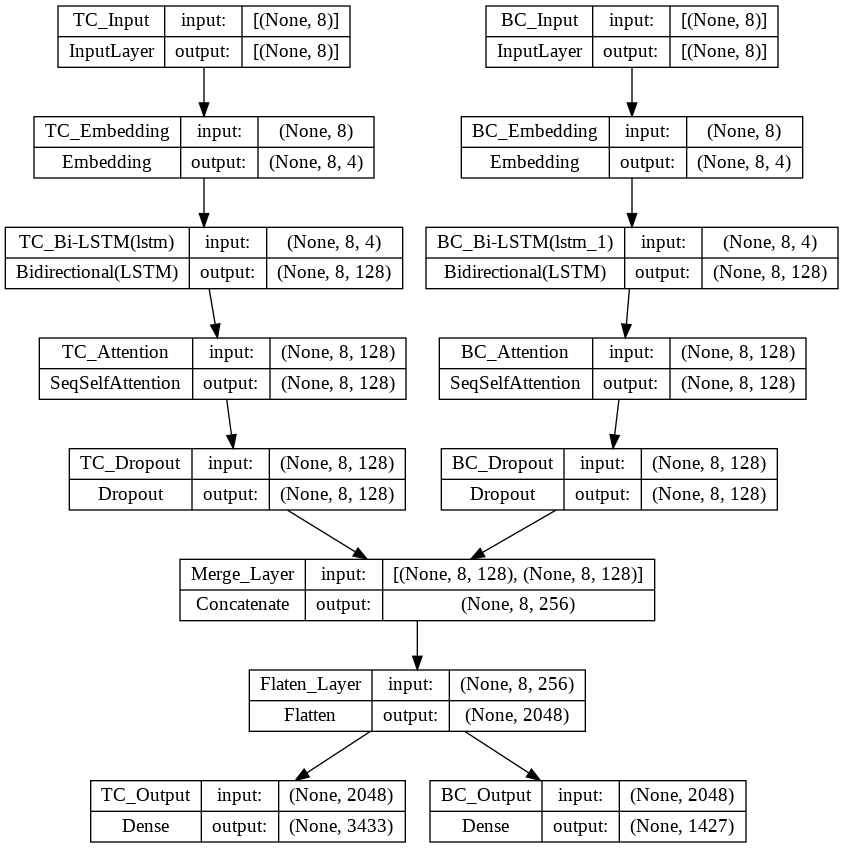

In [ ]:
plot_model(model, to_file='Model(Bi-LSTM with Attention).png', show_shapes=True)

### 모델 학습하기

In [ ]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
        filepath,
        period=20, #Every 20 epochs
        monitor="acc",
        verbose=1,
        save_best_only=False,
        mode='min'
    )
callbacks_list = [checkpoint]

history = model.fit(
    x=(tc_x, bc_x),
    y=(tc_y, bc_y), 
    validation_data=((tc_x[::5], bc_x[::5]), (tc_y[::5], bc_y[::5])), 
    epochs=200, 
    batch_size=128,
    callbacks=callbacks_list)

Epoch 1/200
415/415 [==============================] - 19s 20ms/step - loss: 8.0027 - TC_Output_loss: 5.0312 - BC_Output_loss: 2.9715 - TC_Output_accuracy: 0.1444 - BC_Output_accuracy: 0.6001 - val_loss: 6.7930 - val_TC_Output_loss: 4.3592 - val_BC_Output_loss: 2.4338 - val_TC_Output_accuracy: 0.2009 - val_BC_Output_accuracy: 0.6265
Epoch 2/200
415/415 [==============================] - 7s 16ms/step - loss: 6.5063 - TC_Output_loss: 4.1348 - BC_Output_loss: 2.3715 - TC_Output_accuracy: 0.2431 - BC_Output_accuracy: 0.6229 - val_loss: 6.0222 - val_TC_Output_loss: 3.8043 - val_BC_Output_loss: 2.2179 - val_TC_Output_accuracy: 0.2816 - val_BC_Output_accuracy: 0.6337
Epoch 3/200
415/415 [==============================] - 7s 16ms/step - loss: 5.9620 - TC_Output_loss: 3.7369 - BC_Output_loss: 2.2251 - TC_Output_accuracy: 0.2941 - BC_Output_accuracy: 0.6324 - val_loss: 5.5423 - val_TC_Output_loss: 3.4591 - val_BC_Output_loss: 2.0832 - val_TC_Output_accuracy: 0.3166 - val_BC_Output_accuracy: 0.64

### 모델 학습 결과 그래프

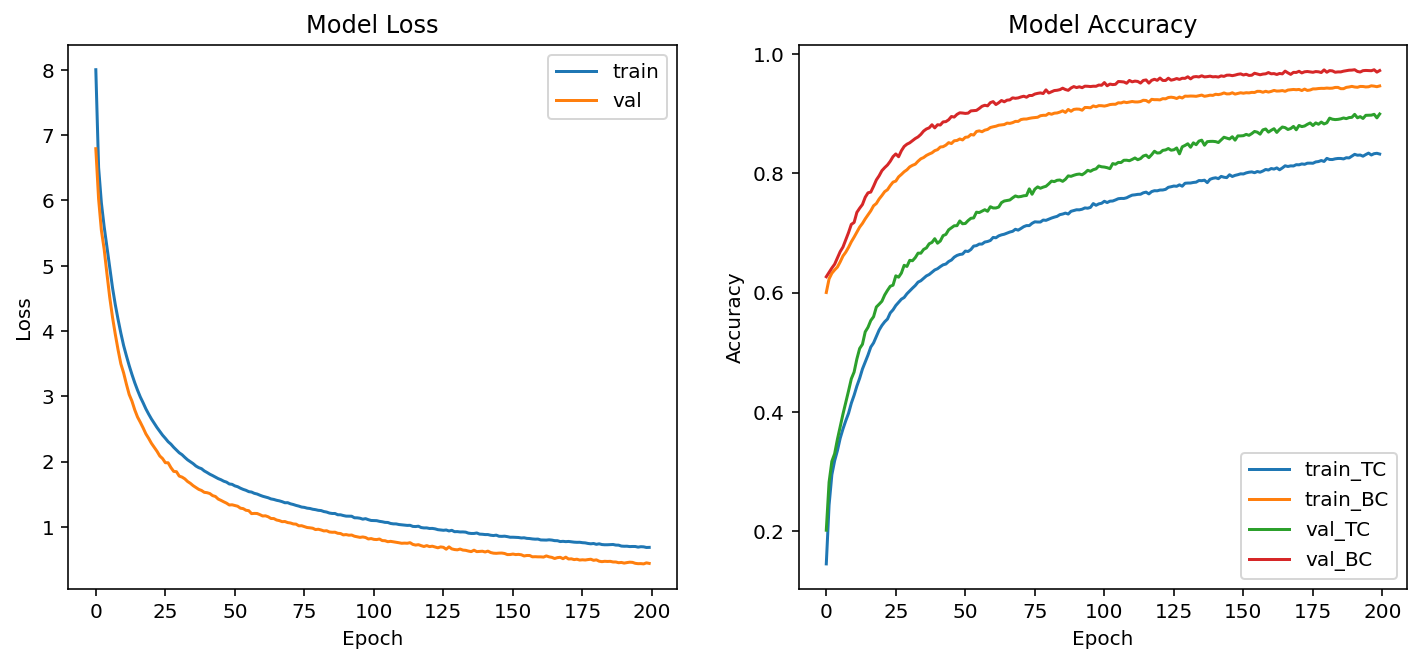

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['TC_Output_accuracy'])
plt.plot(history.history['BC_Output_accuracy'])
plt.plot(history.history['val_TC_Output_accuracy'])
plt.plot(history.history['val_BC_Output_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_TC', 'train_BC', 'val_TC', 'val_BC'], loc='lower right')
plt.savefig('Loss and Accuarcy(Bi-LSTM with Attention Model).png', dpi=300)
plt.show()

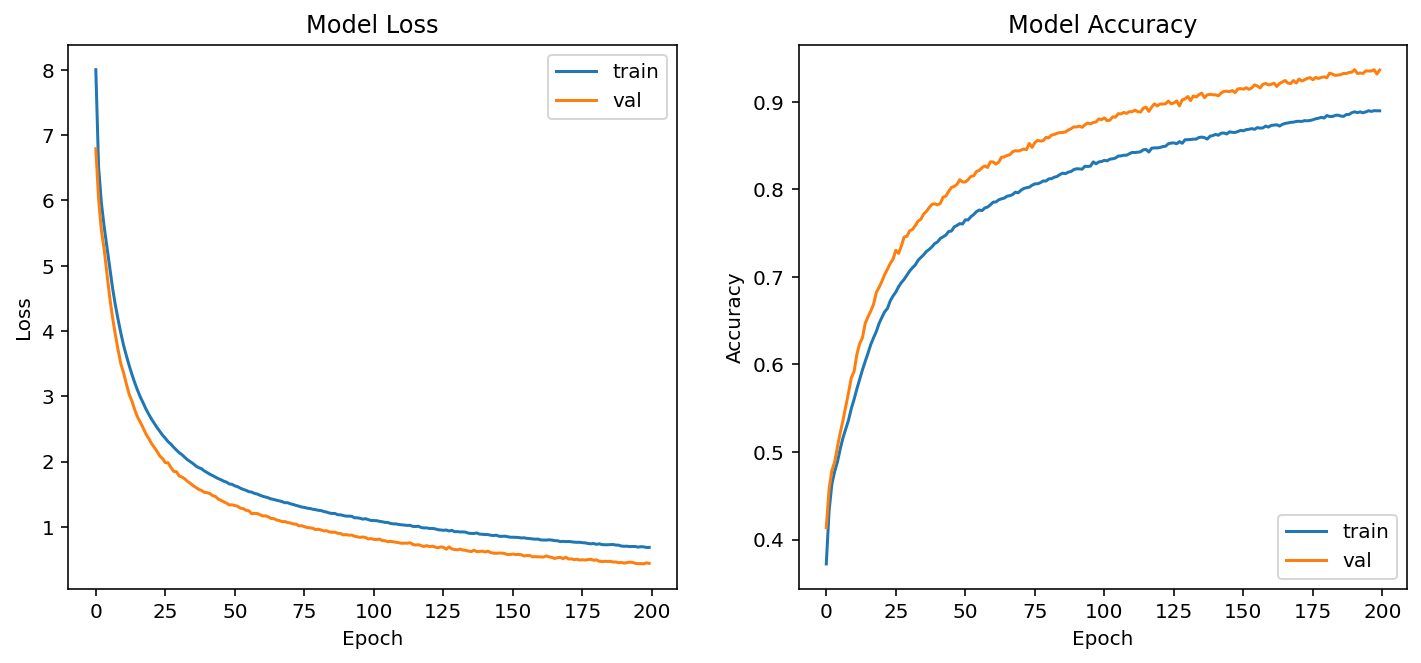

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

train_accuracy = [(
    history.history['TC_Output_accuracy'][i] + 
    history.history['BC_Output_accuracy'][i]) / 2 for i in range(200)]
  
val_accuracy = [(
    history.history['val_TC_Output_accuracy'][i] + 
    history.history['val_BC_Output_accuracy'][i]) / 2 for i in range(200)]

plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig('Loss and Accuarcy(Bi-LSTM with Attention Model)2.png', dpi=300)
plt.show()

### 모델 학습 결과 정확도

In [ ]:
# final_accuracy = (history.history['TC_Output_accuracy'][-1] + history.history['BC_Output_accuracy'][-1]) / 2
# print('높은 음자리 정확도: {:.2f}%'.format(history.history['TC_Output_accuracy'][-1]*100))
# print('낮은 음자리 정확도: {:.2f}%'.format(history.history['BC_Output_accuracy'][-1]*100))
# print('최       종 정확도: {:.2f}%'.format(final_accuracy*100))
for i in range(20, 201, 20):
  i = i - 1
  print(f"Epoch {i + 1}일 때의 정확도:")
  print(f"높은 음자리 - {history.history['TC_Output_accuracy'][i]*100:.2f}%,",
        f"낮은 음자리 - {history.history['BC_Output_accuracy'][i]*100:.2f}%,",
        f"Avg - {train_accuracy[i]*100:.2f}%")


Epoch 20일 때의 정확도:
높은 음자리 - 53.70%, 낮은 음자리 - 75.71%, Avg - 64.70
Epoch 40일 때의 정확도:
높은 음자리 - 63.79%, 낮은 음자리 - 83.82%, Avg - 73.81
Epoch 60일 때의 정확도:
높은 음자리 - 68.74%, 낮은 음자리 - 87.71%, Avg - 78.22
Epoch 80일 때의 정확도:
높은 음자리 - 72.12%, 낮은 음자리 - 89.76%, Avg - 80.94
Epoch 100일 때의 정확도:
높은 음자리 - 74.99%, 낮은 음자리 - 91.37%, Avg - 83.18
Epoch 120일 때의 정확도:
높은 음자리 - 77.08%, 낮은 음자리 - 92.39%, Avg - 84.73
Epoch 140일 때의 정확도:
높은 음자리 - 79.18%, 낮은 음자리 - 93.10%, Avg - 86.14
Epoch 160일 때의 정확도:
높은 음자리 - 80.57%, 낮은 음자리 - 93.66%, Avg - 87.11
Epoch 180일 때의 정확도:
높은 음자리 - 82.01%, 낮은 음자리 - 94.28%, Avg - 88.14
Epoch 200일 때의 정확도:
높은 음자리 - 83.26%, 낮은 음자리 - 94.69%, Avg - 88.97


In [ ]:
for i in range(20, 201, 20):
  i = i - 1
  print(f"epoch {i + 1} 정확도: {train_accuracy[i]*100:.2f}%")

epoch 20 정확도: 64.70%
epoch 40 정확도: 73.81%
epoch 60 정확도: 78.22%
epoch 80 정확도: 80.94%
epoch 100 정확도: 83.18%
epoch 120 정확도: 84.73%
epoch 140 정확도: 86.14%
epoch 160 정확도: 87.11%
epoch 180 정확도: 88.14%
epoch 200 정확도: 88.97%


# 결과물(MIDI파일) 생성하기
---

## 함수 정의

In [ ]:
def convert_to_float(frac_str):
   try:
      return float(frac_str)
   except ValueError:
      num, denom = frac_str.split('/')
      try:
         leading, num = num.split(' ')
         whole = float(leading)
      except ValueError:
         whole = 0
      frac = float(num) / float(denom)
      return whole - frac if whole < 0 else whole + frac

### str to note

In [ ]:
def str_to_note(s):
  temp = s.split(':')
  n = temp[0]
  q = convert_to_float(temp[1])

  if ' ' in n:
    new_chord = chord.Chord(n)
    new_chord.quarterLength = q
    return new_chord
  elif 'rest' in n:
    new_rest = note.Rest(n)
    new_rest.quarterLength = q
    return new_rest
  else:
    new_note = note.Note(n)
    new_note.quarterLength = q
    return new_note

In [ ]:
def nums_to_notes(nums, notes):
   str_notes = []
   for e in notes:
      e = note_to_str(e)
      str_notes.append(e)
   
   int_to_str = dict((k, v) for k, v in enumerate(sorted(set(str_notes))))

   offset = 0.0
   new_notes = []
   for n in nums:
      e = str_to_note(int_to_str[n])
      if e.quarterLength > 0.0:
         e.offset = offset
         new_notes.append(e)
         offset += e.quarterLength

   return new_notes

### generate_notes(model, tc_nums, bc_nums, size)

In [ ]:
def generate_notes(model, tc_nums, bc_nums, size):
  new_tc_nums = []
  new_bc_nums = []
  sl = model.inputs[0].shape[1]
  r_max = min(len(tc_nums), len(bc_nums)) - sl
  r = np.random.randint(0, r_max)

  tc_nums = tc_nums[r:r+sl]
  bc_nums = bc_nums[r:r+sl]
  for i in range(size):
    tc_x = np.reshape(tc_nums, (1, sl))
    bc_x = np.reshape(bc_nums, (1, sl))

    tc_y, bc_y = model.predict([tc_x, bc_x], verbose=0)
    tc_n, bc_n = np.argmax(tc_y), np.argmax(bc_y)

    new_tc_nums.append(tc_n)
    new_bc_nums.append(bc_n)

    tc_nums.append(tc_n)
    bc_nums.append(bc_n)

    tc_nums = tc_nums[1:sl+1]
    bc_nums = bc_nums[1:sl+1]
  
  return new_tc_nums, new_bc_nums


In [ ]:
def create_midi(tc_notes, bc_notes, fp="output/temp.mid", show_txt=False):
   part1 = stream.Part(tc_notes)
   part2 = stream.Part(bc_notes)

   new_stream = stream.Stream([part1, part2])
   if show_txt:
      new_stream.show('txt')
   new_stream.write('midi', fp)

## 실행
---

### 데이터 불러오기

In [ ]:
with open('data/niko/notes', 'rb') as f:
  tc_notes, bc_notes = pickle.load(f)

### 음표를 숫자로 바꾸기

In [ ]:
tc_nums = notes_to_nums(tc_notes)
bc_nums = notes_to_nums(bc_notes)
tc_nums[:10], bc_nums[:10]

([673, 3315, 1532, 1594, 3315, 1532, 1594, 3315, 3328, 1532],
 [116, 1286, 1286, 1286, 1286, 1286, 1286, 1286, 1292, 1286])

### 모델 입출력 데이터 만들기

In [ ]:
tc_x, bc_x, tc_y, bc_y = prepare_sequences(tc_nums, bc_nums, 8)
tc_x.shape, bc_x.shape, tc_y.shape, bc_y.shape # shape 출력

((53001, 8), (53001, 8), (53001, 3433), (53001, 1427))

### 모델 생성 및 가중치 적용하기

In [ ]:
model = createModel(tc_x, bc_x, tc_y, bc_y)
model.load_weights('weights-improvement-200-0.6770-bigger.hdf5')

### 숫자 데이터 생성하기

In [ ]:
new_tc, new_bc = generate_notes(model, tc_nums, bc_nums, 500)
len(new_tc), len(new_bc)

(500, 500)

### 숫자로 된 데이터를 음표로 바꾸기

In [ ]:
new_tc = nums_to_notes(new_tc, tc_notes)
new_bc = nums_to_notes(new_bc, bc_notes)
len(new_tc), len(new_bc)

(416, 167)

### 음자리별 음표 개수 맞추기

In [ ]:
new_tc, new_bc = notes_equally(new_tc, new_bc)
len(new_tc), len(new_bc)

(536, 536)

### MIDI 파일 생성하기

In [ ]:
t = time.strftime("%y%m%d%H%M%S", time.localtime(time.time()))
create_midi(new_tc, new_bc, fp=f"output/niko/output-1BiLSTMAtt-200_{t}.mid", show_txt=True)

{0.0} <music21.stream.Part 0x7f86efc6b850>
    {0.0} <music21.note.Note E>
    {0.25} <music21.note.Rest dotted-eighth>
    {1.0} <music21.note.Rest dotted-eighth>
    {1.6667} <music21.note.Rest zero>
    {1.75} <music21.note.Note F>
    {2.25} <music21.note.Note E>
    {2.75} <music21.note.Note B>
    {3.25} <music21.note.Rest dotted-eighth>
    {4.0} <music21.note.Note A>
    {4.4167} <music21.note.Rest zero>
    {4.5} <music21.note.Rest eighth>
    {5.0} <music21.note.Note D>
    {5.5} <music21.note.Rest eighth>
    {5.6667} <music21.note.Rest zero>
    {6.0} <music21.note.Note B>
    {6.5} <music21.note.Note A>
    {7.0} <music21.note.Note D>
    {7.5} <music21.note.Note E>
    {7.8333} <music21.note.Rest 5/12ql>
    {8.25} <music21.note.Note C>
    {9.3333} <music21.note.Rest zero>
    {10.25} <music21.note.Note E>
    {10.75} <music21.note.Note C>
    {11.25} <music21.note.Note E>
    {11.75} <music21.note.Note C>
    {12.0} <music21.note.Rest 16th>
    {12.25} <music21.note.Not

### MIDI 파일 반복 생성

In [ ]:
loop = 10
for i in range(loop):
  # 숫자 데이터 생성하기
  new_tc, new_bc = generate_notes(model, tc_nums, bc_nums, 500)
  # 숫자로 된 데이터를 음표로 바꾸기
  new_tc = nums_to_notes(new_tc, tc_notes)
  new_bc = nums_to_notes(new_bc, bc_notes)
  # 음자리별 음표 개수 맞추기
  new_tc, new_bc = notes_equally(new_tc, new_bc)
  # MIDI파일 생성하기
  t = time.strftime("%y%m%d%H%M%S", time.localtime(time.time()))
  create_midi(new_tc, new_bc, fp=f"output/niko/output-1BiLSTMAtt-200_{t}.mid")